In [ ]:
!pip install transformers numpy torch sklearn

     |████████████████████████████████| 2.3MB 7.2MB/s 
     |████████████████████████████████| 3.3MB 44.6MB/s 
     |████████████████████████████████| 901kB 43.2MB/s 


In [ ]:
#install required packages
import pandas as pd
import os
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import random
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

In [ ]:
#connect google drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#load training and test data with labels
training_text = pd.read_csv('/gdrive/MyDrive/kaggle/Machathon final round/train_ara.csv')
testing_text = pd.read_csv('/gdrive/MyDrive/kaggle/Machathon final round/test.csv')
labels_text=training_text["intent"].unique()

In [ ]:
print(labels_text)
print(labels_text.shape[0])

['business location' 'nothing identified' 'the evolution of the virus'
 'infected cases' 'crush' 'treatment' 'most vulnerable' 'transfer methods'
 'sterilization and disinfection' 'greeting' 'precautions' 'symptoms'
 'warm weather' 'reviews' 'assessment' 'about corona virus'
 'panic among the people' 'muzzle/mask' 'kindness' 'emergency'
 'laboratory' 'prayers' 'smoking' 'no' 'how are you' 'comparison'
 'about bot' 'food and drinks' 'education and work' 'spoken languages'
 'back to work' 'home quarantine' 'gloves' 'curfew' 'breathing test'
 'about business' 'end conversation' 'yes' 'infection by animals'
 'disease detection']
40


In [ ]:
labels_text=list(range(0,40))

In [ ]:
training_text

,text,intent
0,كم عدد مستشفيات العزل فى مصر وما هى اماكنها,business location
1,ومخاصمك,nothing identified
2,متي ينتهي كورونا؟,the evolution of the virus
3,انا اسف,nothing identified
4,كام عدد الوفيات النهارده,infected cases
...,...,...
786,اهلا,greeting
787,بلح,nothing identified
788,كم عدد الحالات,infected cases
789,متى ينتهى فيروس كورونا,the evolution of the virus


In [ ]:
#load tokenizer
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")

In [ ]:
#load model
model = AutoModelForSequenceClassification.from_pretrained("UBC-NLP/MARBERT", num_labels=len(labels_text)).to("cuda")

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at U

In [ ]:
#split training dataset into training and validation data
def read_dataset(training_text, test_size=0.2):
  
  documents = training_text['text'].tolist()
  labels = training_text['intent'].tolist()
  return train_test_split(documents, labels, test_size=test_size)
  
# call the function
(train_texts, valid_texts, training_labels, valid_labels) = read_dataset(training_text)

In [ ]:
#extract labels from training and validation data
uniq=list(training_text["intent"].unique())
training_labels=[uniq.index(i) for i in training_labels]
valid_labels=[uniq.index(i) for i in valid_labels]

In [ ]:
#tokenize training and validation data
max_length = 512
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [ ]:
#create a torch dataset from encodings and labels
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = Dataset(train_encodings, training_labels)
valid_dataset = Dataset(valid_encodings, valid_labels)

In [ ]:
#define accuracy metrics
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
#set training args
training_args = TrainingArguments(
    output_dir='/gdrive/MyDrive/kaggle/Machathon final round/results',          # output directory
    num_train_epochs=40,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=1000,                # number of warmup steps for learning rate scheduler
    weight_decay=0.015,               # strength of weight decay
    logging_dir='/gdrive/MyDrive/kaggle/Machathon final round/logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=10000,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [ ]:
#calculate distribution of class weights
from sklearn.utils.class_weight import compute_class_weight
uniq=list(training_text["intent"].unique())
labels=[]
labels_2=[]
for index,row in training_text.iterrows():
  labels.append(row["intent"])
for i in labels:
  labels_2.append(uniq.index(i)) 
#compute the class weights
class_wts = compute_class_weight('balanced', np.array(labels_text), labels_2)

print(class_wts)
print(labels)

[1.79772727 0.353125   0.94166667 0.0670339  6.59166667 0.59924242
 4.94375    0.89886364 1.04078947 0.54930556 0.565      0.34094828
 3.29583333 0.47083333 0.68189655 0.94166667 3.955      3.29583333
 3.29583333 6.59166667 3.955      9.8875     9.8875     9.8875
 1.4125     2.825      3.29583333 3.955      9.8875     3.955
 9.8875     2.471875   9.8875     6.59166667 9.8875     4.94375
 9.8875     6.59166667 9.8875     9.8875    ]
['business location', 'nothing identified', 'the evolution of the virus', 'nothing identified', 'infected cases', 'crush', 'treatment', 'infected cases', 'most vulnerable', 'infected cases', 'transfer methods', 'infected cases', 'sterilization and disinfection', 'sterilization and disinfection', 'infected cases', 'infected cases', 'greeting', 'greeting', 'precautions', 'infected cases', 'infected cases', 'infected cases', 'infected cases', 'symptoms', 'infected cases', 'nothing identified', 'infected cases', 'symptoms', 'warm weather', 'transfer methods', 'i

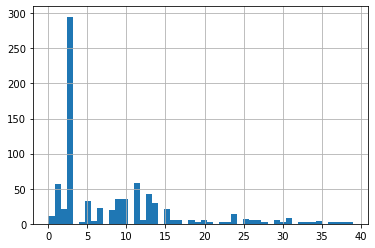

In [ ]:
#plot the distribution of class weights
pd.Series(labels_2).hist(bins = 50)

In [ ]:
#Intialize the trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
#training
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=1600, training_loss=0.03871216297149658, metrics={'train_runtime': 811.1744, 'train_samples_per_second': 1.972, 'total_flos': 889359866449920.0, 'epoch': 40.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 798720, 'train_mem_gpu_alloc_delta': 1303379456, 'train_mem_cpu_peaked_delta': 57344, 'train_mem_gpu_peaked_delta': 430759936})

In [ ]:
#evaluation on validation set
trainer.evaluate()

{'epoch': 40.0,
 'eval_accuracy': 0.7672955974842768,
 'eval_loss': 1.6630570888519287,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 19226624,
 'eval_runtime': 0.794,
 'eval_samples_per_second': 200.259}

In [ ]:
#save final model
model_path = "/gdrive/MyDrive/kaggle/Machathon final round/final classifier"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/gdrive/MyDrive/kaggle/Machathon final round/final classifier/tokenizer_config.json',
 '/gdrive/MyDrive/kaggle/Machathon final round/final classifier/special_tokens_map.json',
 '/gdrive/MyDrive/kaggle/Machathon final round/final classifier/vocab.txt',
 '/gdrive/MyDrive/kaggle/Machathon final round/final classifier/added_tokens.json',
 '/gdrive/MyDrive/kaggle/Machathon final round/final classifier/tokenizer.json')

In [ ]:
#for reusing the model later

#model_path = "/gdrive/MyDrive/kaggle/Machathon final round/Arabic_Ahmed_Shawky_Classifier"
#model=AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=len(training_text)).to("cuda")
#tokenizer=AutoTokenizer.from_pretrained(model_path)

In [ ]:
#calculate predictions
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return probs.argmax()

In [ ]:
#add predictions to numpy array
predictions=[]
uniq=list(training_text["intent"].unique())
for index, row in testing_text.iterrows():
  predictions.append([index,uniq[get_prediction(row["text"]).item()]])
predictions=np.array(predictions)

In [ ]:
pd.DataFrame(predictions, columns = ['index', 'intent']).to_csv("/gdrive/MyDrive/kaggle/Machathon final round/final classifier/pred.csv", index=False)

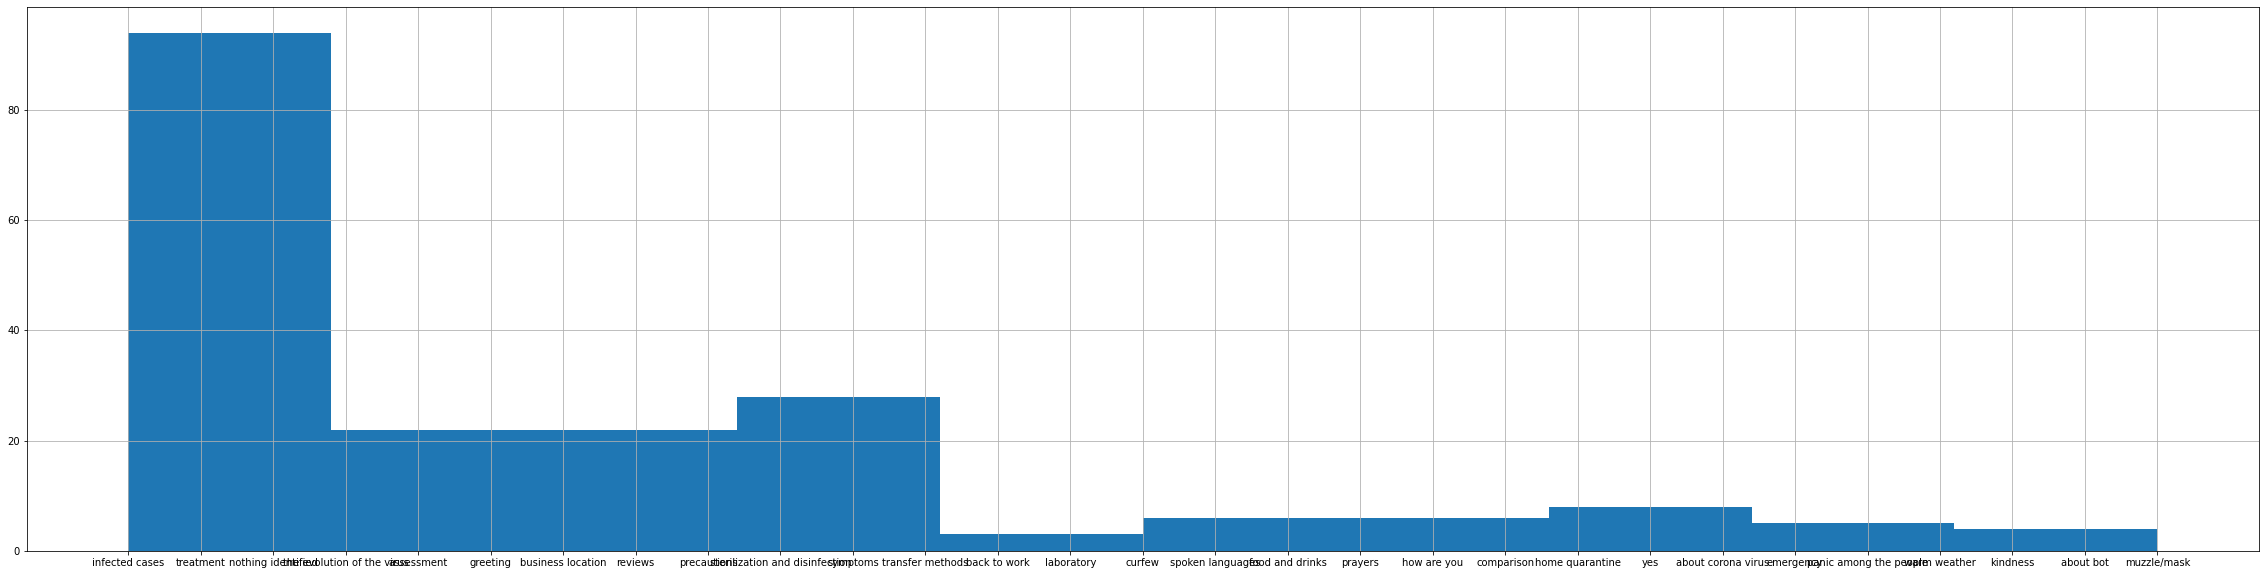

In [ ]:
#plot predictions against different labels
out=[]
for i in predictions:
  out.append(i[1])
pd.Series(x).hist(bins = 10,figsize=(40,10))